# Tarea 2: Construcción de Red Neuronal con Keras

### Óscar Mirones Alonso

En esta práctica trataremos construir una red neuronal para la predicción de lluvia en Lisboa utilizando la libreria de Keras.
Para ello vamos a realizar dos redes diferentes. La primera red se encargará de realizar la clasificación binaria de días en los que llueve y los que no. El umbral considerado para esta discretización es 1mm. Por otro lado, se hará otra red para estimar la cantidad de lluvia que precipita.

In [1]:
library(keras)

Warning message:
"package 'keras' was built under R version 3.6.2"


El primer paso que vamos a realizar es un preprocesado de datos. Como observamos disponemos de muchas variables en nuestro dataset. En clima, es normal y conveniente realizar una selección de variables, ya que algunas de ellas pueden llegar a ser redundantes y dar lugares a problemas en nuestro modelo. Por ello, he decidido calcular las correlaciones y eliminar aquellas columnas que se encuentren entre -0.4 -0.4 (este método ya le utilizamos con Sixto en una práctica de Minería de Datos). Además, se realiza un escalado de los datos, ya que en clima las variables tienen distintas medidas y rangos de valores. Con lo cual, estos dos pasos en el preprocesado de datos son fundamentales.

In [2]:
data = read.csv('meteo.csv')
data = data[-1]
ind.train= 1:8766
ind.test = 8767:10958

corrs = cor(data[-1],data[1], method = 'spearman')
index = which(-0.4 > corrs | corrs > 0.4)

data_x = data[-1]
data_y = data[,1]
data_x = data_x[,index]
target_y_train = data_y[ind.train]
target_y_test = data_y[ind.test]
#escalamos los predictores
predictors_train = scale(data_x[ind.train,])
predictors_test = scale(data_x[ind.test,])
print('Dimensiones:')
print(dim(predictors_train))
print(dim(predictors_test))
print(length(target_y_train))
print(length(target_y_test))

[1] "Dimensiones:"
[1] 8766   37
[1] 2192   37
[1] 8766
[1] 2192


Pasamos a binaria la variable objetivo que será utilizada para la clasificación de ocurrencia de lluvia.

In [3]:
y_binary_train = ifelse(data_y[ind.train] >= 1, 1, 0)
y_binary_test = ifelse(data_y[ind.test] >= 1, 1, 0)

# Modelo de clasificación de ocurrencia de lluvia

La arquitectura es la siguiente:
+ Dos capas, una de 32 neuronas y otra con 64, con activación sigmoidal(se probó relu pero se obtuvieron peores resultados)
+ Una capa de salidad con 1 neurona con activación sigmoidal(dado que es clasificación binaria)

In [5]:
model1 = keras_model_sequential() 

In [6]:
model1 %>% 
  layer_dense(units = 32, input_shape = ncol(predictors_train), activation = "sigmoid") %>% # Primera capa oculta
  layer_dense(units = 64, input_shape = ncol(predictors_train), activation = "sigmoid") %>% # Primera capa oculta
  layer_dense(units = 1, activation='sigmoid') #capa final
str(model1)

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 32)                      1216        
________________________________________________________________________________
dense_1 (Dense)                     (None, 64)                      2112        
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       65          
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
________________________________________________________________________________




Como optimizador usaremos Adam Optimization ya que suele funcionar bien con cualquier tipo de red combinando SGD con momentum y RMSprop. Como función de pérdida tenemos la binary crossentropy ya que es un problema de clasificación binaria. Como métrica se usa el AUC.

In [7]:
model1 %>% compile(
  optimizer = 'adam',
  loss = "binary_crossentropy",
  metrics = "AUC"
)

En el fit añadimos:
+ Entrenamiento en 100 épocas
+ Tamaño de batch de 100, ya que nuestro dataset es pequeño
+ Se hace un validation split a partir del conjunto de train
+ Early stopping para evitar incurrir en sobreajuste

Trained on 7,012 samples (batch_size=100, epochs=100)
Final epoch (plot to see history):
    loss: 0.2898
     AUC: 0.9148
val_loss: 0.2809
 val_AUC: 0.9226 

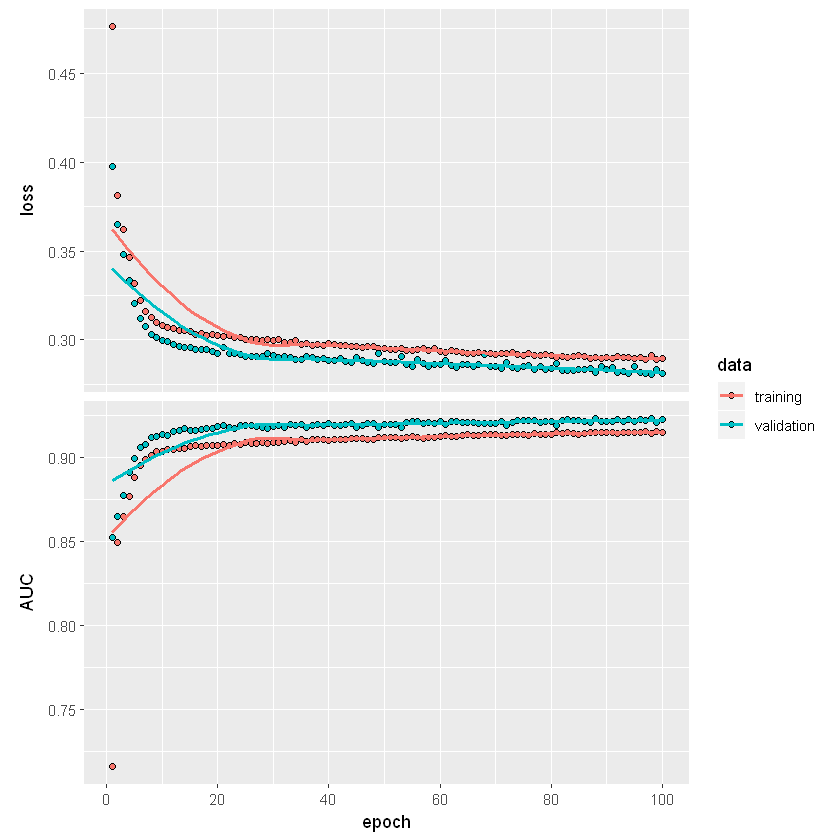

In [8]:
history = model1 %>% fit(predictors_train, y_binary_train, epochs = 100, batch_size = 100,
                        validation_split=0.2,
                        callbacks = callback_early_stopping(patience = 20))
history
plot(history)

Observamos que en las 100 épocas no se ha incurrido en sobreajuste y el error desciende progresivamente así como el AUC aumenta, obteniendo un AUC bastante alto y un error bajo.

Veamos como realiza la predicción con el conjunto de test.

In [10]:
library(caret)
pred = predict_classes(model1,predictors_test)
confusionMatrix(as.factor(pred),as.factor(y_binary_test))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1690  137
         1  116  249
                                          
               Accuracy : 0.8846          
                 95% CI : (0.8705, 0.8977)
    No Information Rate : 0.8239          
    P-Value [Acc > NIR] : 2.569e-15       
                                          
                  Kappa : 0.5935          
                                          
 Mcnemar's Test P-Value : 0.2086          
                                          
            Sensitivity : 0.9358          
            Specificity : 0.6451          
         Pos Pred Value : 0.9250          
         Neg Pred Value : 0.6822          
             Prevalence : 0.8239          
         Detection Rate : 0.7710          
   Detection Prevalence : 0.8335          
      Balanced Accuracy : 0.7904          
                                          
       'Positive' Class : 0               
                        

Parece que el modelo generaliza bastante bien.

In [11]:
model1 %>% save_model_hdf5("modelo_occ.h5")

# Modelo de predicción de cantidad de lluvia

En este caso hemos tenido que realizar varios intentos para tener una arquitectura que funcionase adecuadamente. Durante las pruebas hemos tenido que lidiar con un problema de sobreajuste, por ello hemos empleado técnicas para generalizar nuestro modelo. Estas técnicas son el dropout. La estructura de la red es la siguiente:
+ Dos capas densas con 25 y 50 neuronas con función de activación sigmoidal. Hemos probado con relu pero obteniamos peores resultados.
+ Después de cada capa densa aplicamos un dropout con probabilidad de 0.5. Esto apagará neuronas aleatoriamente, haciendo más sencillo el modelo, aporta una mayor generalización al modelo y evita que algún nodo se sobreespecialice. Del mismo modo, evita que un input dependa de un cierto nodo en concreto.
+ Una capa de salida con una neurona con una activación lineal, dado que buscamos una regresión.

In [13]:
model2 = keras_model_sequential() 

In [14]:
model2 %>% 
  layer_dense(units = 25, input_shape = ncol(predictors_train), activation = "sigmoid") %>% # Primera capa oculta
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 50, input_shape = ncol(predictors_train), activation = "sigmoid") %>% # 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1, activation = 'linear') #capa final
str(model2)

Model
Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_3 (Dense)                     (None, 25)                      950         
________________________________________________________________________________
dropout (Dropout)                   (None, 25)                      0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 50)                      1300        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_5 (Dense)                     (None, 1)                       51          
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_____________

Al igual que en el anterior modelo, optamos por usar Adam ya que nos ha dado buenos resultados. En este caso la función de pérdida será MSE y como métrica hemos elegido MAE.

In [15]:
model2 %>% compile(
  optimizer = 'adam', 
  loss = "mse",
  metrics = 'mae')

En el fit tenemos:
+ Entrenamiento con 500 épocas. En este caso es necesario un mayor entrenamiento.
+ Un validation split sobre el conjunto de train
+ Early Stopping para evitar sobreajuste.

Trained on 7,012 samples (batch_size=32, epochs=383)
Final epoch (plot to see history):
    loss: 25.37
     mae: 2.098
val_loss: 23.32
 val_mae: 2.072 

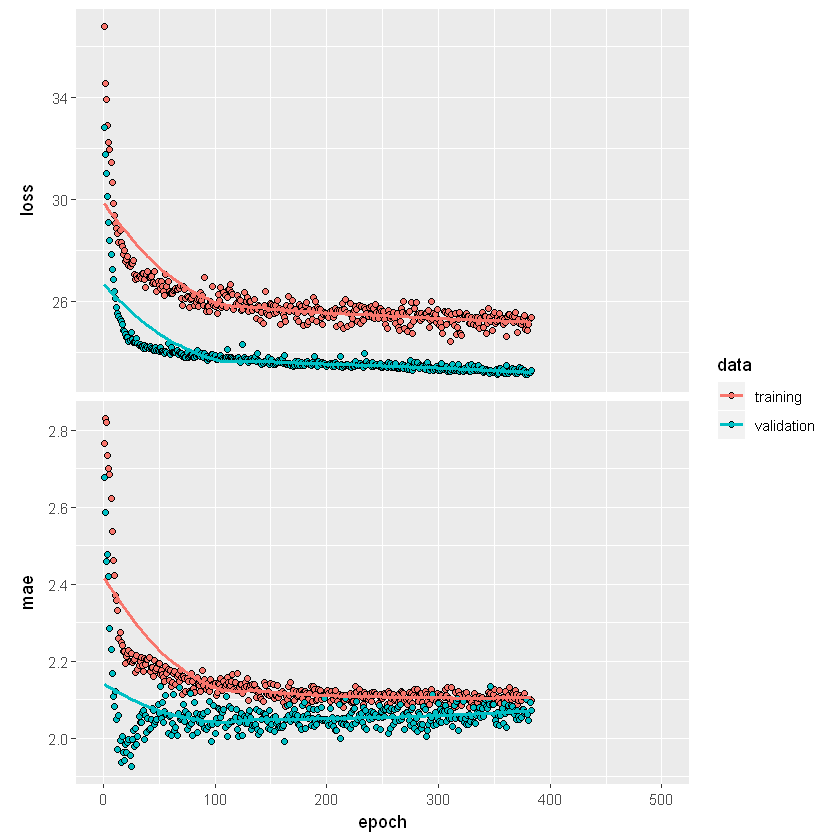

In [16]:
history = model2 %>% fit(predictors_train, target_y_train, epochs = 500,validation_split=0.2,
                        callbacks = callback_early_stopping(patience = 30))
history
plot(history)

Observamos que el early stopping para el entrenamiento en la época 383, a partir de ahí tendriamos sobreajuste en nuestro modelo. Vemos que el mse y el mae de los conjuntos de train y validation son bastante similares, siendo incluso menores los de validation. Los valores que obtenemos de MAE no son muy grandes ya que rondan un valor cercano al 2. Sin embargo el MSE no es todo lo pequeño que quisieramos.

In [17]:
model2 %>% evaluate(predictors_test,target_y_test,verbose = 0)

$loss
[1] 33.07815

$mae
[1] 2.141

El MAE es similar a lo obtenido en train, sin embargo el MSE es alto en comparación con lo obtenido en el entrenamiento

In [18]:
model2 %>% save_model_hdf5("modelo_cant.h5")

# Combinación de la ocurrencia y cantidad

Aquí vamos a observar si combinando los resultados anteriores tenemos un mejor resultado en la predicción de cantidad. Es una técnica común en precipitación ya que lo hemos realizado previamente en otras asignaturas. Para evaluar el error de predicción vamos a utilizar el Root Mean Square Error (RMSE). Con lo cual, multiplicamos ocurrencia x cantidad y evaluamos el error entre ese resultado y el y_test. Del mismo modo hacemos lo mismo con la predicción solamente con el modelo de cantidad y el y_test.

In [19]:
occ = predict_classes(model1,predictors_test)
head(occ)

1
1
1
1
1
1


In [20]:
cant = predict(model2,predictors_test)
head(cant)

4.982473
7.321963
4.271374
3.617287
11.086777
3.091226


In [21]:
combined = occ*cant

In [23]:
rmse <- function(obs, pred) {
  stopifnot(identical(length(obs), length(pred)))
  sqrt(mean(pred - obs)^2)
}

In [36]:
tabla = matrix(c(rmse(combined,target_y_test),cor(combined,target_y_test, method = 'spearman'),
                var(combined)/var(target_y_test),rmse(cant,target_y_test),
                cor(cant,target_y_test, method = 'spearman'),var(cant)/var(target_y_test)),ncol=3,byrow=TRUE)
colnames(tabla) = c('rmse', 'spearman cor', 'variance ratio')
rownames(tabla) = c('Occ x Cant', 'cant')
tabla

,rmse,spearman cor,variance ratio
Occ x Cant,0.5618244,0.6259277,0.2735677
cant,0.1356118,0.5924332,0.2482172


Notamos que practicamente se obtienen resultados similares en ambas aproximaciones. De hecho, hemos comprobado que tenemos aun así un menor error al utilizar la predicción solamente con el modelo de cantidad sin combinar la ocurrencia.

Para una futura mejora del modelo podrían sugerirse varios cambios:

+ Adquirir más datos y aumentar tiempos de entrenamiento
+ Modificar la estructura de la red
+ Realizar cambios en la regularización del modelo

In [76]:
k_clear_session()